# Taller 2

In [1]:
import os

os.environ["USE_PYGEOS"] = "0"

import datacube
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from odc.ui import DcViewer
from datacube.utils import masking
from datacube.utils.cog import write_cog
from datacube.utils.rio import configure_s3_access

from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

In [2]:
dc = datacube.Datacube(app='sampleo') 

## Carga de puntos de muestreo

In [3]:
mr = gpd.read_file("vectores/muestreo_regular_300m.shp")
ma = gpd.read_file("vectores/muestreo_aleatorio.shp")

¿Cuántos puntos existen para los muestreos, para cada tipo de uso?

Muestreo sistemático:

In [4]:
mr.groupby(["nivel_1"])["nivel_1"].count()

nivel_1
0          9
100       79
200     1440
300     2787
400     2296
500       14
600      158
800        6
900       28
1000       1
Name: nivel_1, dtype: int64

Muestreo aleaotorio

In [5]:
ma.groupby(["nivel_1"])["nivel_1"].count()

nivel_1
0         24
100      130
200     2161
300     4088
400     3308
500       13
600      220
800       14
900       41
1000       1
Name: nivel_1, dtype: int64

In [6]:
cuencas = gpd.read_file("vectores/Cuencas_BNA.shp")
cuenca = cuencas.loc[cuencas.COD_CUEN == "070"]
x0, y0, x1, y1 = cuenca.to_crs(4326).bounds.values[0]

## Carga de imágenes

### Landcover Zhao 2014

In [7]:
query = {
    "product": ["landcover_chile_2014"],
    "y": (y0, y1), 
    "x": (x0, x1),
    "time": ("2014-01-01", "2023-12-31"),
    "output_crs": "EPSG:32719",
    "resolution": (-30, 30),
    "dask_chunks": {"time": 1, 'x':2048, 'y':2048},
    # "group_by": "solar_day"
}

lc = dc.load(**query).squeeze()
lc

<xarray.Dataset>
Dimensions:      (y: 1019, x: 1434)
Coordinates:
    time         datetime64[ns] 2014-12-31
  * y            (y) float64 6.156e+06 6.156e+06 ... 6.125e+06 6.125e+06
  * x            (x) float64 2.08e+05 2.081e+05 2.081e+05 ... 2.51e+05 2.51e+05
    spatial_ref  int32 32719
Data variables:
    nivel_1      (y, x) uint16 dask.array<chunksize=(1019, 1434), meta=np.ndarray>
    nivel_2      (y, x) uint16 dask.array<chunksize=(1019, 1434), meta=np.ndarray>
    nivel_3      (y, x) uint16 dask.array<chunksize=(1019, 1434), meta=np.ndarray>
Attributes:
    crs:           epsg:32719
    grid_mapping:  spatial_ref

In [8]:
write_cog(lc.nivel_1, "land_cover_2014_070.tif", overwrite=True).compute()

PosixPath('land_cover_2014_070.tif')

<Axes: title={'center': 'time = 2014-12-31 [seconds since 1970-01-01 00:...'}, xlabel='x [metre]', ylabel='y [metre]'>

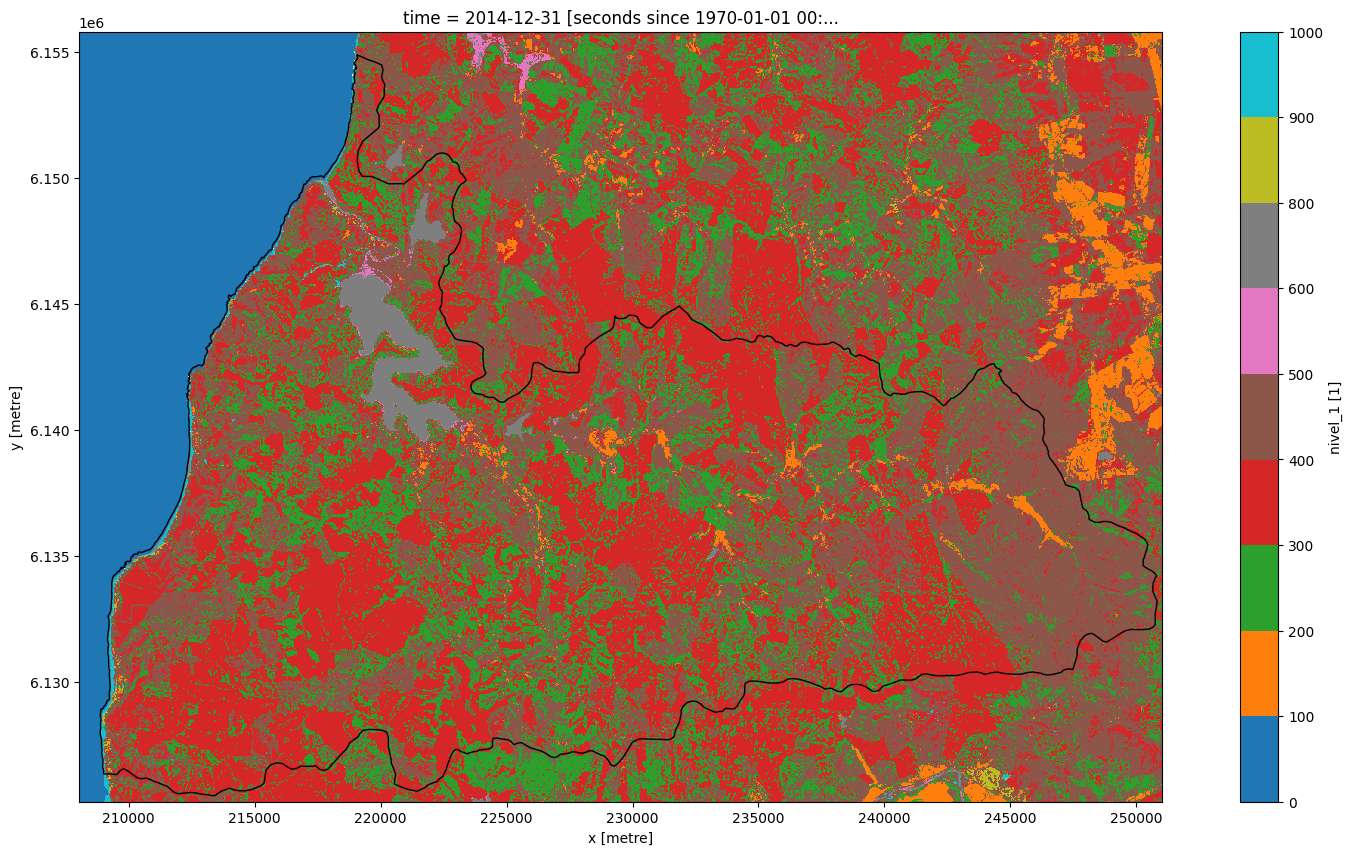

In [9]:
fig = plt.figure(figsize=(20,10))
ax_ = fig.add_subplot(111)

lc.nivel_1.plot(cmap="tab10", levels=[0, 100, 200, 300, 400, 500, 600, 800, 900, 1000], ax=ax_)
cuenca.plot(ax=ax_, facecolor='none', edgecolor='black')

### Serie Landsat-8

In [10]:
query["product"] = "landsat8_c2l2_sr"
ds = dc.load(**query)
ds

<xarray.Dataset>
Dimensions:      (time: 395, y: 1019, x: 1434)
Coordinates:
  * time         (time) datetime64[ns] 2014-01-09T14:35:20.781400 ... 2023-10...
  * y            (y) float64 6.156e+06 6.156e+06 ... 6.125e+06 6.125e+06
  * x            (x) float64 2.08e+05 2.081e+05 2.081e+05 ... 2.51e+05 2.51e+05
    spatial_ref  int32 32719
Data variables:
    coastal      (time, y, x) uint16 dask.array<chunksize=(1, 1019, 1434), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 1019, 1434), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 1019, 1434), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 1019, 1434), meta=np.ndarray>
    nir08        (time, y, x) uint16 dask.array<chunksize=(1, 1019, 1434), meta=np.ndarray>
    swir16       (time, y, x) uint16 dask.array<chunksize=(1, 1019, 1434), meta=np.ndarray>
    swir22       (time, y, x) uint16 dask.array<chunksize=(1, 1019, 1434), meta=np.ndarray>
    qa_pixel     (time, y, x) uint16 dask.array<chunksize=(1, 1019, 1434), meta=np.ndarray>
    qa_aerosol   (time, y, x) uint8 dask.array<chunksize=(1, 1019, 1434), meta=np.ndarray>
    qa_radsat    (time, y, x) uint16 dask.array<chunksize=(1, 1019, 1434), meta=np.ndarray>
Attributes:
    crs:           epsg:32719
    grid_mapping:  spatial_ref

In [11]:
quality_band = 'qa_pixel'
refl_bands = ["red", "nir08", "blue"]
cloud_free_mask = (
    masking.make_mask(ds[quality_band], snow='high_confidence') + 
    masking.make_mask(ds[quality_band], cloud="high_confidence") +
    masking.make_mask(ds[quality_band], cirrus="high_confidence") +
    masking.make_mask(ds[quality_band], cloud_shadow="high_confidence") +
    masking.make_mask(ds[quality_band], nodata=True)
)
dsf = xr.where(cloud_free_mask, np.nan, ds[refl_bands])
dsf.update(dsf * 0.0000275 + -0.2)
dsf.update(dsf.where(dsf >= 0).where(dsf <= 1))

<xarray.Dataset>
Dimensions:      (time: 395, y: 1019, x: 1434)
Coordinates:
  * time         (time) datetime64[ns] 2014-01-09T14:35:20.781400 ... 2023-10...
  * y            (y) float64 6.156e+06 6.156e+06 ... 6.125e+06 6.125e+06
  * x            (x) float64 2.08e+05 2.081e+05 2.081e+05 ... 2.51e+05 2.51e+05
    spatial_ref  int32 32719
Data variables:
    red          (time, y, x) float64 dask.array<chunksize=(1, 1019, 1434), meta=np.ndarray>
    nir08        (time, y, x) float64 dask.array<chunksize=(1, 1019, 1434), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 1019, 1434), meta=np.ndarray>

In [12]:
ndvi = (dsf['nir08'] - dsf['red']) / (dsf['nir08'] + dsf['red'])
ndvi.attrs = ds.attrs

evi = 2.5 * ((dsf['nir08'] - dsf['red']) / (dsf['nir08'] + 6 * dsf['red'] - 7.5 * dsf['blue'] + 1))
evi.attrs = ds.attrs

ndvi

<xarray.DataArray (time: 395, y: 1019, x: 1434)>
dask.array<truediv, shape=(395, 1019, 1434), dtype=float64, chunksize=(1, 1019, 1434), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2014-01-09T14:35:20.781400 ... 2023-10...
  * y            (y) float64 6.156e+06 6.156e+06 ... 6.125e+06 6.125e+06
  * x            (x) float64 2.08e+05 2.081e+05 2.081e+05 ... 2.51e+05 2.51e+05
    spatial_ref  int32 32719
Attributes:
    crs:           epsg:32719
    grid_mapping:  spatial_ref

> Observe como funciona el cluster en el link: https://hub.datacubechile.cl/user/MI_USUARIO/proxy/8787/status (reemplace MI_USUARIO por su nombre de usuario)

In [13]:
ndvi = ndvi.compute()

/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


In [14]:
evi = evi.compute()

/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, 'EVI')

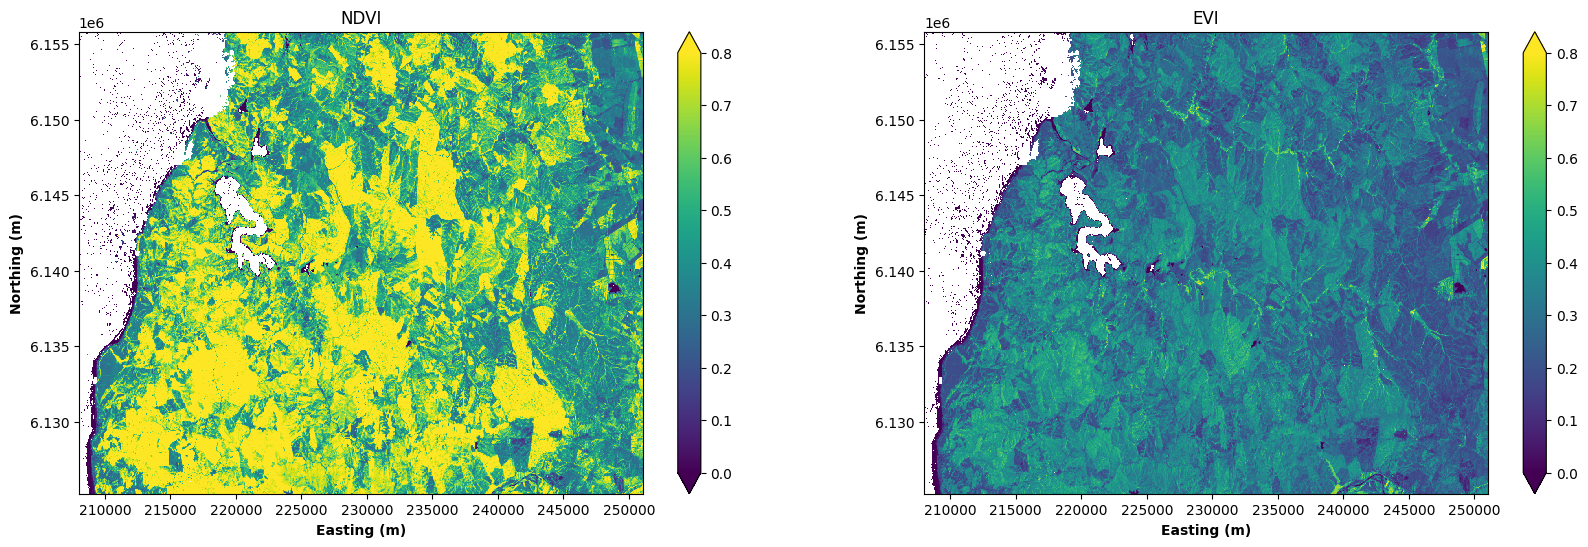

In [15]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ndvi.isel(time=0).plot(robust=True, ax=ax1, vmin=0, vmax=.8)
ax1.set_xlabel('Easting (m)', fontweight='bold')
ax1.set_ylabel('Northing (m)', fontweight='bold')
ax1.set_title("NDVI")

evi.isel(time=0).plot(robust=True, ax=ax2, vmin=0, vmax=.8)
ax2.set_xlabel('Easting (m)', fontweight='bold')
ax2.set_ylabel('Northing (m)', fontweight='bold')
ax2.set_title("EVI")

## Extracción de serie temporal

In [16]:
puntos = ma.loc[(ma.nivel_1 == 200) & (ma.id.isin([73, 4440, 7555]) )]  # bosque

In [17]:
# Con esto puedo elegir 10 puntos al azar del tipo de land cover especificado
# puntos = ma.loc[(ma.nivel_1 == 200)].sample(10)  # bosque

In [18]:
puntos

,id,nivel_1,geometry
73,73,200,POINT (239384.458 6138018.588)
4440,4440,200,POINT (219398.470 6137810.565)
7555,7555,200,POINT (235772.385 6132017.638)


In [19]:
x_ = xr.DataArray(puntos.geometry.x)
y_ = xr.DataArray(puntos.geometry.y)
valores = ndvi.sel(x=x_, y=y_, method="nearest").values

vfv = pd.DataFrame(valores, columns=puntos.id, index=ndvi.time)
vfv

id,73,4440,7555
2014-01-09 14:35:20.781400,0.673927,0.718769,0.733076
2014-01-16 14:41:24.037691,NaN,NaN,NaN
2014-01-25 14:35:11.681981,0.705620,0.735559,0.731054
2014-02-01 14:41:18.704590,0.526542,0.727925,0.794809
2014-02-10 14:34:58.757746,0.661992,NaN,NaN
...,...,...,...
2023-08-14 14:33:59.062269,NaN,NaN,NaN
2023-08-30 14:34:04.471428,NaN,NaN,0.503973
2023-09-06 14:40:12.762816,NaN,NaN,NaN
2023-09-15 14:34:08.102769,0.792649,0.783533,0.851316


<Axes: >

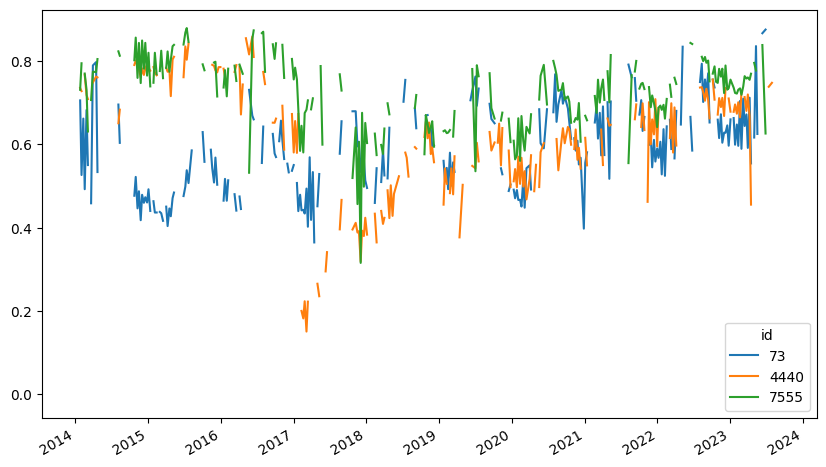

In [20]:
vfv.plot(figsize=(10, 6))

<Axes: >

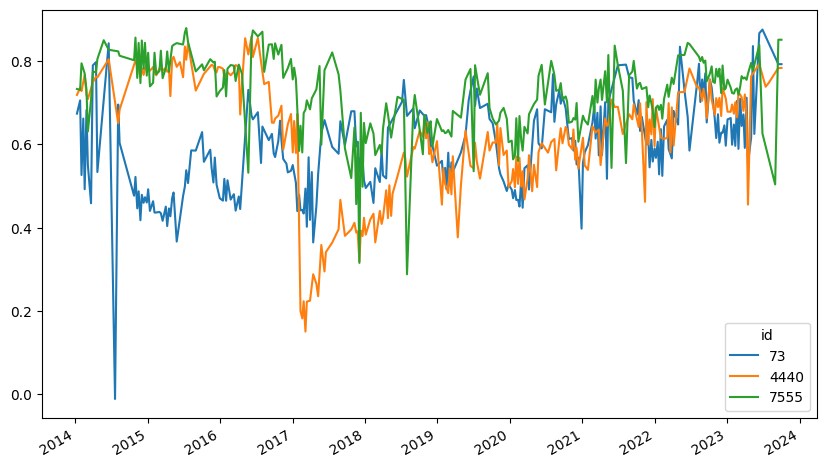

In [21]:
vfv.interpolate(method="time").plot(figsize=(10, 6))

<Axes: title={'center': 'time = 2014-12-31 [seconds since 1970-01-01 00:...'}, xlabel='x [metre]', ylabel='y [metre]'>

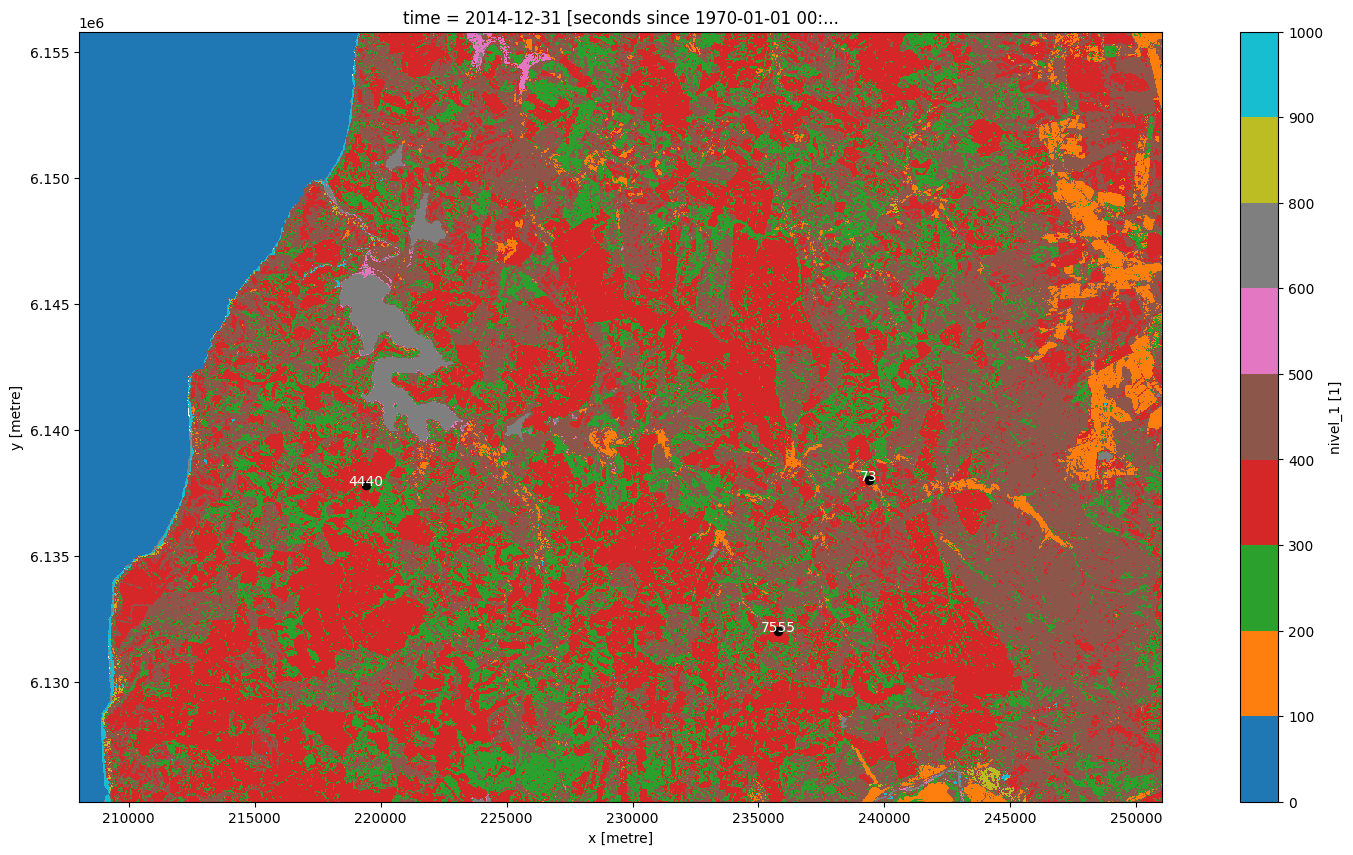

In [22]:
fig = plt.figure(figsize=(20,10))
ax_ = fig.add_subplot(111)

lc.nivel_1.plot(cmap="tab10", levels=[0, 100, 200, 300, 400, 500, 600, 800, 900, 1000], ax=ax_)
puntos.apply(lambda x: ax_.annotate(text=x.id, xy=x.geometry.centroid.coords[0], ha='center', color="white"), axis=1)
puntos.plot(ax=ax_, color='black')

In [23]:
vfv.to_csv("bosques.csv")

## Extracción de datos para análisis espacial

***IMPORTANTE***: revise los valores de salida hagan sentido y estén en rangos válidos de información. Si es necesario, filtre por los valores de landcover que son de interés.

> Seleccione aleatoriamente la misma cantidad de puntos que existen en el conjunto de datos de la grilla regular (6818), en el conjunto de datos del muestreo aleatorio. Hágalo de manera aleatoria utilizando `ma.sample(n)`.

In [24]:
import xrspatial as xrs

In [25]:
query["product"] = "copernicus_dem_30"
dem = dc.load(**query).squeeze(drop=True)

slope = xrs.slope(dem.elevation).to_dataset()  # en grados
aspect = xrs.aspect(dem.elevation).to_dataset()

In [26]:
mt = "2017-02-09"  # fecha objetivo

ndvi_ = ndvi.sel(time=mt).squeeze()
ndvi_.name = "ndvi"
evi_ = evi.sel(time=mt).squeeze()
evi_.name = "evi"

In [27]:
mdata = xr.merge([ndvi_, evi_, dem, slope, aspect])
mdata

<xarray.Dataset>
Dimensions:      (y: 1019, x: 1434)
Coordinates:
    time         datetime64[ns] 2017-02-09T14:40:12.899143
  * y            (y) float64 6.156e+06 6.156e+06 ... 6.125e+06 6.125e+06
  * x            (x) float64 2.08e+05 2.081e+05 2.081e+05 ... 2.51e+05 2.51e+05
    spatial_ref  int32 32719
Data variables:
    ndvi         (y, x) float64 0.3754 0.2687 0.06106 ... 0.4278 0.5031 0.4866
    evi          (y, x) float64 0.003235 0.004187 0.001951 ... 0.1826 0.1509
    elevation    (y, x) float32 dask.array<chunksize=(1019, 1434), meta=np.ndarray>
    slope        (y, x) float64 dask.array<chunksize=(1019, 1434), meta=np.ndarray>
    aspect       (y, x) float64 dask.array<chunksize=(1019, 1434), meta=np.ndarray>
Attributes:
    crs:           epsg:32719
    grid_mapping:  spatial_ref

In [28]:
x_ = xr.DataArray(ma.geometry.x, dims=["id"], coords={"id": ma.id})
y_ = xr.DataArray(ma.geometry.y, dims=["id"], coords={"id": ma.id})
valores = mdata.sel(x=x_, y=y_, method="nearest").to_array()
_ = valores.to_pandas().T
# ma_data = pd.DataFrame({"x": ma.geometry.x, "y": ma.geometry.y, "id": ma.id}).join(_).set_index("id")
ma_data = pd.DataFrame({"x": ma.geometry.x.values, "y": ma.geometry.y.values}, index=ma.id).join(_)

In [29]:
x_ = xr.DataArray(mr.geometry.x, dims=["id"], coords={"id": mr.id})
y_ = xr.DataArray(mr.geometry.y, dims=["id"], coords={"id": mr.id})
valores = mdata.sel(x=x_, y=y_, method="nearest").to_array()
_ = valores.to_pandas().T
# mr_data = pd.DataFrame({"x": mr.geometry.x, "y": mr.geometry.y, "id": mr.id}).join(_).set_index("id")
mr_data = pd.DataFrame({"x": mr.geometry.x.values, "y": mr.geometry.y.values}, index=mr.id).join(_)

## Circular/Cyclical Encoding

¿Qué sucede con variables que tienen un ciclo, pero numericamente no lo representan, como las horas del día, meses, ángulos, etc?

In [30]:
def circular_encode(data: pd.Series):
    radians = np.radians(data)
    sin_values = np.sin(radians)
    cos_values = np.cos(radians)
    ans = pd.concat([sin_values, cos_values], axis=1)
    ans.columns = ["aspect_sin", "aspect_cos"]
    return ans

In [31]:
ma_dataf = pd.concat([ma.set_index("id").nivel_1, ma_data, circular_encode(ma_data['aspect'])], axis=1)
ma_dataf

,nivel_1,x,y,ndvi,evi,elevation,slope,aspect,aspect_sin,aspect_cos
id,,,,,,,,,,
0,400,224843.779795,6.138410e+06,0.397774,0.176977,20.520544,7.422561,78.745583,0.980770,0.195166
1,200,213681.246514,6.137155e+06,0.711232,0.299432,193.617157,17.446407,266.544067,-0.998181,-0.060281
2,600,220543.233200,6.142688e+06,-0.349088,-0.012875,0.000000,0.000000,-1.000000,-0.017452,0.999848
3,400,234208.716857,6.134705e+06,0.435791,0.216066,67.137871,4.130885,275.021027,-0.996163,0.087521
4,300,231120.262913,6.144118e+06,0.489909,0.250466,254.944489,9.370442,130.756927,0.757486,-0.652851
...,...,...,...,...,...,...,...,...,...,...
9995,400,224869.150279,6.128091e+06,0.781982,0.430460,262.786377,26.868307,8.504772,0.147892,0.989004
9996,200,226556.360941,6.128919e+06,0.657941,0.201986,275.459900,26.121429,290.688904,-0.935512,0.353294
9997,400,222456.961910,6.146840e+06,0.317122,0.151998,49.987370,26.269627,288.664185,-0.947411,0.320021


In [32]:
mr_dataf = pd.concat([mr.set_index("id").nivel_1, mr_data, circular_encode(mr_data['aspect'])], axis=1)
mr_dataf

,nivel_1,x,y,ndvi,evi,elevation,slope,aspect,aspect_sin,aspect_cos
id,,,,,,,,,,
4519,300,219165.2812,6154699.845,0.833773,0.315359,86.742989,15.964077,186.061340,-0.105593,-0.994409
4520,400,219465.2812,6154699.845,0.730479,0.355929,129.705276,8.323690,295.223297,-0.904654,0.426147
4741,400,219165.2812,6154399.845,0.443944,0.233351,44.240818,17.417210,26.567919,0.447258,0.894405
4742,400,219465.2812,6154399.845,0.849870,0.375023,93.651382,20.117327,272.317963,-0.999182,0.040445
4743,300,219765.2812,6154399.845,0.864666,0.317018,168.699203,29.871904,261.804169,-0.989787,-0.142557
...,...,...,...,...,...,...,...,...,...,...
26029,200,211965.2812,6125599.845,0.429849,0.180562,312.472290,6.814016,11.874886,0.205775,0.978599
26030,300,212265.2812,6125599.845,0.317162,0.162140,301.550629,7.346320,40.247070,0.646085,0.763266
26032,300,212865.2812,6125599.845,0.332545,0.156035,272.112488,10.287471,354.545349,-0.095058,0.995472


In [33]:
ma_dataf.to_csv("muestreo_aleatorio.csv")
mr_dataf.to_csv("muestreo_regular.csv") 

In [34]:
client.close()
cluster.close()